## Import dependencies

In [63]:
# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# customized preprocessing functions
import util

# standard libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time
import matplotlib.pyplot as plt


# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# models
from pmdarima import auto_arima
import statsmodels.api as sm
import xgboost as xgb

## Import data

In [64]:
data_path = "../00_data"

df_rapperswil = pd.read_csv(os.path.join(data_path, "features_rapperswil.csv"), sep=",")
df_burgdorf = pd.read_csv(os.path.join(data_path, "features_burgdorf.csv"), sep=",")

print('Dataset shape of Rapperswil data: {}'.format(df_rapperswil.shape))
print('Dataset shape of Burgdorf data: {}'.format(df_burgdorf.shape))

df_rapperswil['date'] = pd.to_datetime(df_rapperswil['date'])
df_burgdorf['date'] = pd.to_datetime(df_burgdorf['date'])

Dataset shape of Rapperswil data: (12317, 18)
Dataset shape of Burgdorf data: (7782, 18)


In [65]:
#  declare categorical columns
for col in ['hour', 'day_of_week', 'quarter', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'weather', 'holiday']:
    df_rapperswil[col] = df_rapperswil[col].astype(object)
    df_burgdorf[col] = df_burgdorf[col].astype(object)

## Preprocessing

In [66]:
def split_features(df, label=None):
    X = df[[# 'date_only', (is not as a feature and kept out-commented to have overview of source data)
             'hour',
             'day_of_week',
             'quarter',
             'month',
             'day_of_year',
             'day_of_month',
             'week_of_year',
             'temperature',
             'weather',
             'holiday',
             't-7',
             't-3',
             't-2',
             't-1']]
    if label:
        y = df[label]
        return X, y
    return X

Split data into train and test data using 70/30% ratio by considering the order of the time series

In [67]:
# set datetime column as index
df_burgdorf.set_index('date', inplace = True)
# df_rapperswil.set_index('date', inplace = True)

In [68]:
# identify split date manually and use beginning of the month of the specific date
# e.g. 2021-08-16 04:00:00 --> 2021-08-01 01:00:00, only for pragmatic reasons for better paper story
train = 0.7 * len(df_burgdorf)
df_burgdorf[:int(train)].index.max()

Timestamp('2021-08-16 04:00:00')

In [69]:
def split(df, split_date):
    
    # define split date
    # split_date = datetime.strptime(split_date, '%Y-%m-%d %H:%M:%S').date()
    split_date = datetime.strptime(split_date, '%Y-%m-%d %H:%M:%S')
    
    # split df into train and test set
    df_train = df.loc[df.index <= split_date].copy()
    df_test = df.loc[df.index > split_date].copy()
    
    # set date as index in both sets
    # df_train = df_train.set_index('date')
    # df_test = df_test.set_index('date')
    
    return df_train, df_test

In [70]:
# df_train, df_test = split(df_rapperswil, '2021-07-01 01:00:00')
df_train, df_test = split(df_burgdorf, '2021-08-01 01:00:00')

In [71]:
# split data sets
X_train, y_train = split_features(df_train, label='occupancy_rate')
X_test, y_test = split_features(df_test, label='occupancy_rate')

**Feature standardization and scaling** \
Features vary in magnitude and units, which is why we apply feature scaling using `StandardScaler()` for numeric features and `OneHotEncoder()` for categorical features. For example, the input value `day_of_week` should not be used as a continuous value from 1 to 7, since this would mean that the last weekdays (5, 6 or 7) are associated to a higher
weight than the first ones (1,2 and 3).

In [72]:
# split numerical and categorical columns
data_num = X_train.select_dtypes(include=[np.number])
data_cat = X_train.select_dtypes(include=[np.object])

# check whether no columns got lost during type allocation
len(X_train.columns) == len(data_num.columns) + len(data_cat.columns)

# create data pipeline
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        # don’t take precautions to handle unseen values for OneHotEncoder
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_attribs)])

# fit and transform training data set with preprocessing pipeline and
# only transform test feature set with the pipeline fit on training feature set to not
# artificially improve test performance

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

True

## 1. Random forest

For hyperparameter optimization, we apply `random grid search` with cross validation to narrow down the range of reasonable values for the given parameters for the models. Then, `full grid search` with cross validation is applied with the value range obtained from the random grid search.

1) Define random grid

In [73]:
# number of trees in random forest
n_estimators = [x for x in range(200, 2000, 25)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# important note - consider regularization for the next run

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

2) Run grid search

In [ ]:
# use the random grid to search for best hyperparameters

# create random forest model
rf = RandomForestRegressor(random_state = 42)

# ensure prediction is made on subsequent data
cv = TimeSeriesSplit(n_splits=3)

# random search of parameters, using 3 fold cross validation, 
# search across 75 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = cv,
                               verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf_random.fit(X_train, y_train)

#s how best parameters
print('Best parameters:')
rf_random.best_params_

3) Define new grid with optimal value range

In [ ]:
# define more specific grid

# number of trees in random forest
n_estimators = [x for x in range(200, 2000, 25)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

4) Run grid search

In [ ]:
# create random forest model
rf = RandomForestRegressor(random_state = 42)

# ensure prediction is made on subsequent data
cv = TimeSeriesSplit(n_splits=3)

# random search of parameters, using 3 fold cross validation, 
# search across 75 different combinations, and use all available cores
rf = GridSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = cv,
                               verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf.fit(X_train, y_train)

# show best parameters
print('Best parameters:')
rf.best_params_

5) Fit model with optimal parameters

In [56]:
rf = RandomForestRegressor(random_state = 42,
                           n_estimators = 600,
                           max_features = 'auto',
                           max_depth = 20,
                           min_samples_split = 2,
                           min_samples_leaf = 2)

In [77]:
# fit the random search model
rf.fit(X_train, y_train)

# run prediction
df_test['random_forest'] = rf.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=600,
                      random_state=42)

In [78]:
print('MAE: ', round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest']), 2))
print('RMSE: ', round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest'], squared=False), 2))

MAE:  2.26
RMSE:  3.36


## 2. XGBoost

1) Define random grid

In [74]:
# number of trees in random forest
n_estimators = [x for x in range(200, 2000, 25)]

# learning rate
arr = np.arange(0.01, 1.0, 0.05)
eta = arr.tolist()

# defines the minimum sum of weights of all observations required in a child
min_child_weight = [i for i in range(1, 100, 8)]

# maximum depth of a tree
max_depth = [i for i in range(1, 250, 5)]

# regularization
gamma = [0, 1, 5]

# number of columns used by each tree
colsample_bytree = [0.8, 0.9, 1]

# maximum number of leaf nodes in tree
max_leaf_nodes = [i for i in range(10, 300, 5)]
max_leaf_nodes.append(None)

# create random grid
random_grid = {'n_estimators' : n_estimators,
               'eta' : eta,
               'max_depth': max_depth,
               # 'max_features': max_features,
               'min_child_weight': min_child_weight,
               'gamma' : gamma,
               'colsample_bytree' : colsample_bytree,
               'max_leaf_nodes': max_leaf_nodes}

2) Run random grid search

In [75]:
# create xgb model
xgb = xgb.XGBRegressor(random_state=42)

# ensure prediction is made on subsequent data
cv = TimeSeriesSplit(n_splits=3)

# random search of parameters, using 3 fold cross validation, 
# search across 75 different combinations, and use all available cores
xbg_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 75, cv = cv,
                               verbose=2, random_state=42, n_jobs = -1)
# fit the xgboost model
start = time.time()
xbg_random.fit(X_train, y_train)
end = time.time()
print(end - start)

# show best parameters
print('Best parameters:')
xbg_random.best_params_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min


KeyboardInterrupt: 

3) Define new grid with optimal value range

4) Run grid search

5) Optimal parameters obtained from last random grid search

In [ ]:
xgb = xgb.XGBRegressor(n_estimators = 600,
                            min_child_weight = 17,
                            max_leaf_nodes = 110,
                            # max_features = 'auto',
                            max_depth = 51,
                            gamma = 0,
                            eta = 0.01,
                            colsample_bytree = 0.9,
                            random_state=42)

In [ ]:
# fit the random search model
xgb.fit(X_train, y_train)

# run prediction
# give meaningful column name, e.g. "prediction_xgb_all_features"
df_test['xgb_all_features'] = xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

Best Performance: 3.93 (MAE), 6.03 (RMSE) 

In [ ]:
print('MAE: ', round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test['xgb_all_features']), 2))
print('RMSE: ', round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test['xgb_all_features'], squared=False), 2))

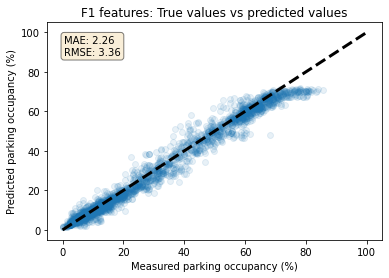

In [118]:
# plot the true target values for the test set versus the estimated values with the best model
plt.scatter(df_test['occupancy_rate'], df_test['random_forest'], alpha=0.1);
plt.plot([0, 100], [0, 100], "k--", lw=3);
plt.xlabel('Measured parking occupancy (%)');
plt.ylabel('Predicted parking occupancy (%)');
plt.title('F1 features: True values vs predicted values');

# provide MAE and RMSE details to the plot
textstr = '\n'.join((
    r'MAE: %.2f' % (mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest'])),
    r'RMSE: %.2f' % (mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test['random_forest'], squared=False))
))

# style infobox
ax.hist(x, 20)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0.03, 0.95, textstr, verticalalignment='top', bbox=props, transform=ax.transAxes)

# export - pay attention to an appropriate name
file = 'f1_features.png'
plt.savefig('../05_visualisations_of_eda/' + file);